<a href="https://www.kaggle.com/code/maryamayman20/fruits-objectdetection?scriptVersionId=184750075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Fruit Object Detection

![](http://)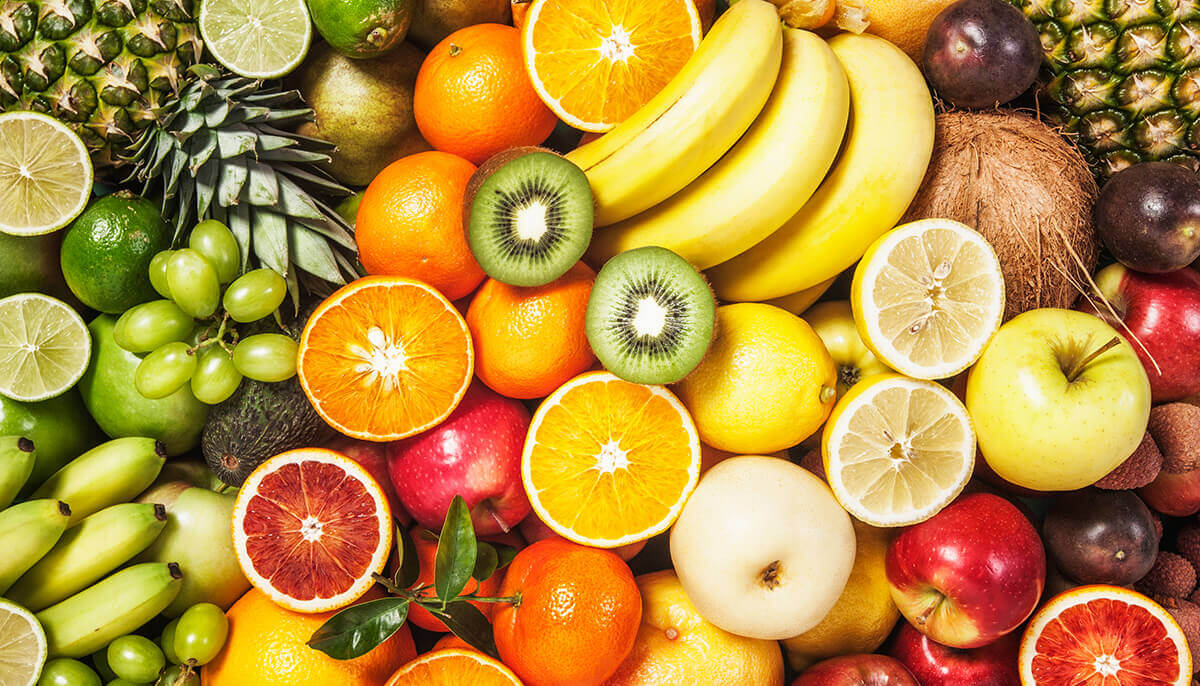

In [1]:
from IPython import display
display.clear_output()

!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 667.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.5/792.5 kB 4.6 MB/s eta 0:00:00


In [2]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch
from torchvision import transforms, datasets
from PIL import Image, ImageDraw, ImageFont
from torch.utils.data import Dataset, DataLoader
from ultralytics import YOLO
from IPython import display
import random

In [3]:
#activate gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Prepare datasets

In [4]:
#dirs
data = '../input/fruit-detection/Fruits-detection' 

traindir    = os.path.join(data, 'train/images')
trainlabels = os.path.join(data,'train/labels') 

valdir    = os.path.join(data,'valid/images') 
vallabels = os.path.join(data,'valid/labels' )

In [5]:
def files(images, labels):
    image_files = glob.glob(os.path.join(images, '*.jpg'))
    labels_files = glob.glob(os.path.join(labels, '*.txt'))
    
    return image_files, labels_files

In [6]:
#files
train_image_files, train_labels_files = files(traindir, trainlabels)
val_image_files, val_labels_files = files(valdir, vallabels)

train_image_files.sort()
train_labels_files.sort()
val_image_files.sort()
val_labels_files.sort()

In [7]:
print(len(train_image_files), len(train_labels_files))

7108 7108


In [8]:
class dataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None, draw_box= False):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.draw_box = draw_box
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label_path = self.label_paths[index]
        
        labels = []
        image = Image.open(image_path)
        image = image.resize((500, 500))
        draw = ImageDraw.Draw(image)

        classes = ['Apple', 'Banana', 'Grape', 'Orange', 'Pineapple', 'Watermelon'] 
        colors = ['yellow', 'red', 'pink', 'green', 'blue', 'orange']
        # Open the file and read its content
        with open(label_path, 'r') as file:
            lines = file.readlines()

        for line in lines:
            if line.strip():
                parts = line.strip().split()
                class_num = int(parts[0])
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                x_min = int((x_center - width / 2) * 500)
                y_min = int((y_center - height / 2) * 500)
                x_max = int((x_center + width / 2) * 500)
                y_max = int((y_center + height / 2) * 500)

                labels.append((class_num, x_min, y_min, x_max, y_max))
                if self.draw_box == True:
                    draw.rectangle([x_min, y_min, x_max, y_max], outline= colors[class_num], width=10)
                    draw.text((x_min, y_min), f"{classes[class_num]}", fill= 'white')

        if self.transform:
            image = self.transform(image)

        return image, labels
            
    def __len__(self):
        return len(self.image_paths)
        

In [9]:
train_dataset = dataset(train_image_files, train_labels_files, None, True)
val_dataset = dataset(val_image_files, val_labels_files, None, False)

# Show some images with its labels and box

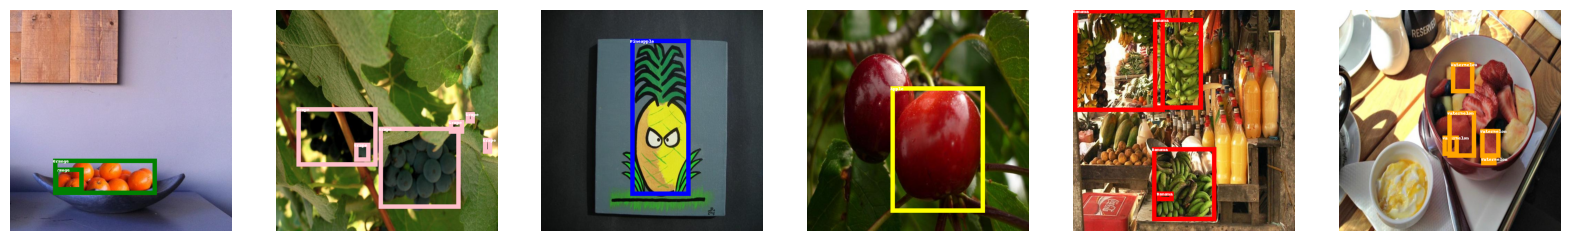

In [10]:
indxs = [603,160, 900, 20, 446, 80]
temp =0
fig, axes = plt.subplots(1, 6, figsize=(20, 10))
for i in indxs:
        image, labels = train_dataset[i]
        axes[temp].imshow(image)
        axes[temp].axis('off')
        temp = temp +1
        
plt.show()

# Training and validation

In [11]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 79.5MB/s]


In [12]:
import yaml
from pathlib import Path
import wandb
wandb.init(mode='disabled')


data = {
    'train': "/kaggle/input/fruit-detection/Fruits-detection/train",
    'val': "/kaggle/input/fruit-detection/Fruits-detection/valid",
    'nc': 6,  
    'names' : 
        ['Apple',
         'Banana',
         'Grape',
         'Orange',
         'Pineapple', 
         'Watermelon' ]
}

with open('data.yaml', 'w') as file:
    yaml.dump(data, file)

yaml_path = 'data.yaml'

#os.system('python train.py --img 500 --batch 16 --epochs 20 --data data.yaml --weights yolov8s.pt')
model.train(data=yaml_path, imgsz=500, batch=32, epochs=20)

Ultralytics YOLOv8.2.38 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=500, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]
2024-06-21 14:35:42,053	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-21 14:35:42,824	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/fruit-detection/Fruits-detection/train/labels... 7108 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7108/7108 [00:18<00:00, 394.05it/s]

train: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/train/images/3d8be4f881b8c54c_jpg.rf.0d7b6d095459cece040b47b246d807af.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/train/images/3d8be4f881b8c54c_jpg.rf.64e869a9bedd5f012cc2a1129c6ca229.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/fruit-detection/Fruits-detection/valid/labels... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:02<00:00, 396.78it/s]

val: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       3.5G      1.087      2.533      1.256         58        512: 100%|██████████| 223/223 [01:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]

                   all        914       3227      0.324      0.237      0.176     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      4.35G      1.042       1.72      1.216        139        512: 100%|██████████| 223/223 [00:56<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.74it/s]


                   all        914       3227      0.415      0.335      0.285      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.03G      1.025      1.582      1.205         17        512: 100%|██████████| 223/223 [00:56<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]


                   all        914       3227      0.359       0.24      0.192      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.79G      1.001      1.503      1.198         25        512: 100%|██████████| 223/223 [00:56<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


                   all        914       3227      0.385      0.318      0.279      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.38G     0.9764      1.385      1.181         18        512: 100%|██████████| 223/223 [00:55<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


                   all        914       3227      0.443      0.314      0.303      0.177

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.75G     0.9464      1.303      1.164         12        512: 100%|██████████| 223/223 [00:55<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.80it/s]


                   all        914       3227      0.466      0.359      0.337      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.53G     0.9264      1.238      1.149         19        512: 100%|██████████| 223/223 [00:55<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


                   all        914       3227      0.465      0.325      0.321      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.48G     0.9163      1.197      1.145         29        512: 100%|██████████| 223/223 [00:55<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.78it/s]


                   all        914       3227      0.486      0.394      0.379      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.63G     0.8922      1.155      1.134         47        512: 100%|██████████| 223/223 [00:55<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


                   all        914       3227      0.498       0.39      0.392      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      4.11G     0.8712      1.099      1.116         69        512: 100%|██████████| 223/223 [00:55<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


                   all        914       3227      0.539      0.367      0.387      0.239
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.63G     0.8784      1.057      1.112          6        512: 100%|██████████| 223/223 [00:54<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]


                   all        914       3227      0.496      0.381       0.39      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.15G     0.8729     0.9795      1.109         21        512: 100%|██████████| 223/223 [00:52<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.91it/s]


                   all        914       3227      0.488      0.398        0.4      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.28G     0.8483       0.94      1.089          7        512: 100%|██████████| 223/223 [00:53<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]


                   all        914       3227       0.54      0.406      0.426      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.38G     0.8387     0.9073       1.08          9        512: 100%|██████████| 223/223 [00:52<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]

                   all        914       3227      0.594      0.396      0.442      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      3.32G     0.8165     0.8492      1.069         17        512: 100%|██████████| 223/223 [00:53<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


                   all        914       3227      0.563      0.417      0.441      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.81G     0.8124     0.8227      1.065         31        512: 100%|██████████| 223/223 [00:52<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]

                   all        914       3227      0.599      0.428      0.473      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      3.51G     0.7941     0.7887      1.054         36        512: 100%|██████████| 223/223 [00:52<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.91it/s]

                   all        914       3227      0.583      0.437      0.464      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       3.4G     0.7768     0.7619      1.048          6        512: 100%|██████████| 223/223 [00:52<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]

                   all        914       3227      0.581      0.423      0.457      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.48G     0.7646     0.7412      1.041         22        512: 100%|██████████| 223/223 [00:53<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.87it/s]


                   all        914       3227      0.565      0.442      0.471      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.62G     0.7448     0.7034      1.031         11        512: 100%|██████████| 223/223 [00:52<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]

                   all        914       3227      0.618      0.438      0.492       0.33



20 epochs completed in 0.341 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.38 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


                   all        914       3227      0.624      0.437      0.492       0.33
                 Apple        188        557      0.647      0.445       0.52      0.362
                Banana        167        390      0.659       0.45      0.509      0.308
                 Grape        199        809      0.611      0.367      0.396      0.265
                Orange        197       1100       0.64      0.363      0.426      0.269
             Pineapple         77        154      0.664      0.455      0.529      0.354
            Watermelon        107        217      0.521      0.544       0.57      0.422
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b94120bd8a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [13]:
model.val(data=yaml_path)

Ultralytics YOLOv8.2.38 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/input/fruit-detection/Fruits-detection/valid/labels... 914 images, 0 backgrounds, 0 corrupt: 100%|██████████| 914/914 [00:01<00:00, 906.03it/s]

val: WARNING ⚠️ /kaggle/input/fruit-detection/Fruits-detection/valid/images/3d3ddc3054b32eb7_jpg.rf.03e7789aaf5212e2634b84ef502e0832.jpg: 1 duplicate labels removed


val: WARNING ⚠️ Cache directory /kaggle/input/fruit-detection/Fruits-detection/valid is not writeable, cache not saved.


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


                   all        914       3227      0.619      0.438      0.492       0.33
                 Apple        188        557      0.648      0.445      0.521      0.362
                Banana        167        390      0.651      0.451      0.509      0.308
                 Grape        199        809      0.606      0.367      0.396      0.265
                Orange        197       1100      0.631      0.364      0.426      0.268
             Pineapple         77        154      0.662      0.455      0.525      0.354
            Watermelon        107        217      0.516      0.544      0.572      0.421
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b94123b8760>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

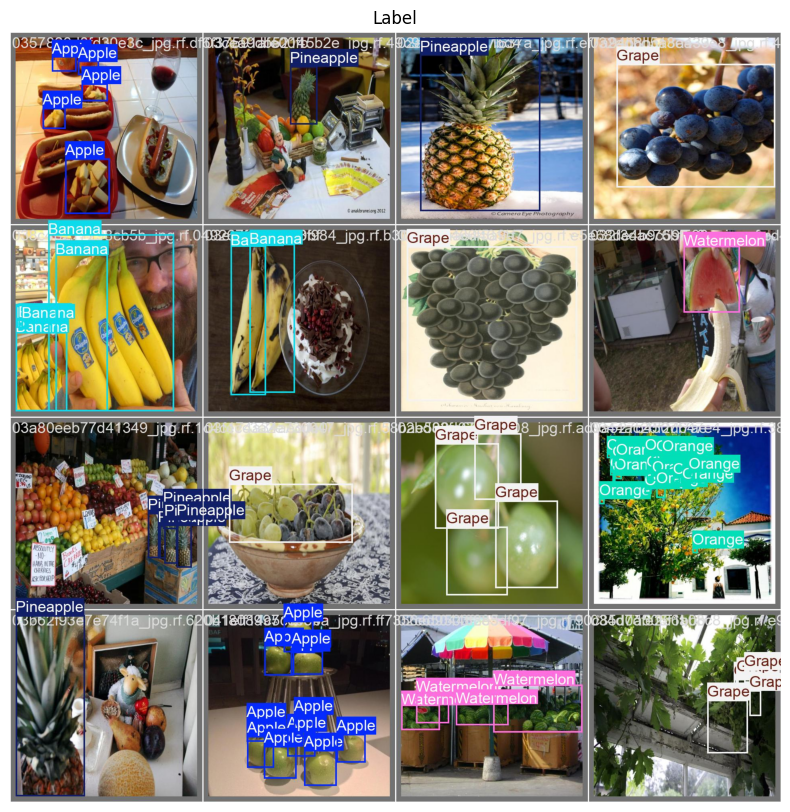

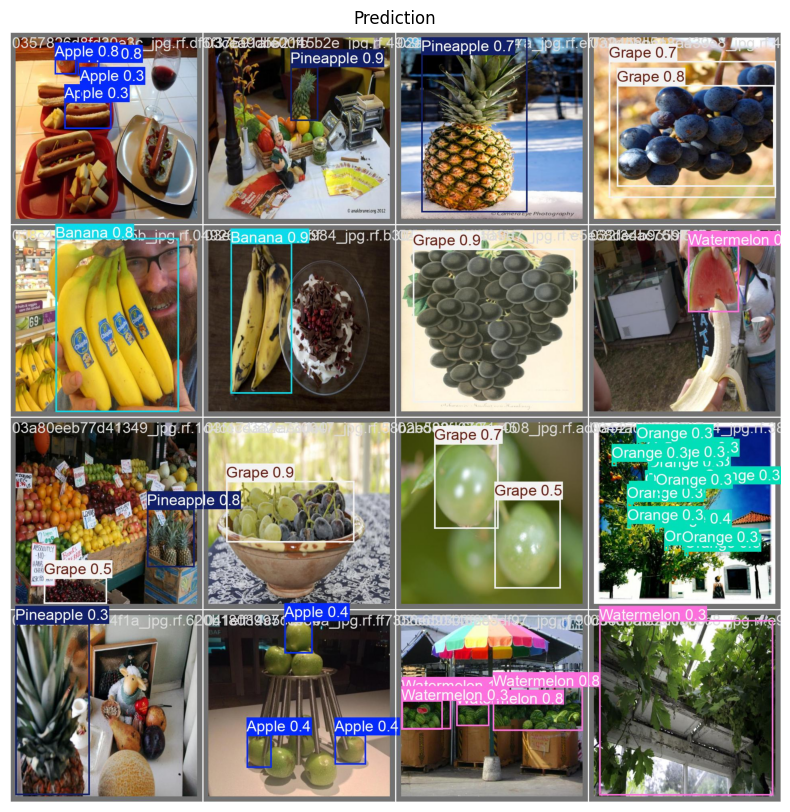

In [14]:
val_label = Image.open("/kaggle/working/runs/detect/train2/val_batch1_labels.jpg")
val_pred = Image.open("/kaggle/working/runs/detect/train2/val_batch1_pred.jpg") 

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

# save the model

In [15]:
model.save('/kaggle/working/best.pt')